# Twitter Sentiment Analysis - POC
---

## 6. Train a couple baseline models

Before throwing a bunch of models at the data, I first retrain the Naive Bayes and Logistic Regression models from the last notebook with learning curves to test whether more data improves them. The hypothesis is that they're too simple for data volume to improve accuracy. Instead of using the entire $1.2M$ dataset, I use a subset of approximately $250k$ rows randomly sampled from the training data.

In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd
import scipy.sparse as sp

import cleanup_module_POC as Cmod

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
# time notebook
start_notebook = time.time()

# load minimally prepared X, y train subsets
raw_path = os.path.join("..","data","1_raw","sentiment140")
X_train = pd.read_csv(os.path.join(raw_path, "X_train.csv"))
y_train = pd.read_csv(os.path.join(raw_path, "y_train.csv"))

### Sample down to $m\approx250k$

In [3]:
X, X_rest, y, y_rest = train_test_split(X_train, y_train, test_size=0.79, random_state=42)

In [4]:
# check
print(f'Dataset size: {len(X):0.0f}')
print(f'Target distribution: {sum(y["target"])/len(y):0.3f}')

Dataset size: 251468
Target distribution: 0.500


In [5]:
# transform into arrays
X_array = np.array(X.iloc[:, 2]).ravel()
y_array = y.iloc[:,0].ravel()

# save y array
# processed dir
proc_dir = os.path.join("..","data","3_processed","sentiment140")

with open(os.path.join(proc_dir, "y_array_250k.npy"), 'wb') as f:
    np.save(f, y_array)

### Pre-process subset with 1,000 features

Since pre-processing with a larger feature space takes time, I'll establish a naming convention for saving pre-processed data which includes the following scheme: 
- X train or test
- transformed (for clarification)
- representation (BoW, Tfidf, etc.)
- m: in 1000s (k)
- n: in 1000s (k)


In [6]:
try:
    # load X_train_transformed 
    X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_BoW_250k_1k.npz"))
    print('Loading X_train_transformed...')
except:
    print('Preprocessing X_array as BoW with m=250k, n=1k...')
    preprocess_pipeline = Pipeline([
        ("document_to_wordcount", Cmod.DocumentToWordCounterTransformer()),
        ("wordcount_to_vector", Cmod.WordCounterToVectorTransformer()), # default is n=1k
    ])
    start_pipeline = time.time()
    X_train_transformed = preprocess_pipeline.fit_transform(X_array) # currently 250k
    # save preprocessed data
    sp.save_npz(os.path.join(proc_dir, 'X_train_transformed_BoW_250k_1k.npz'), X_train_transformed)
    # print processing time
    mins, secs = divmod(time.time() - start_pipeline, 60)
    print(f'Preprocessing time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')
    # Preprocessing time: 2 minute(s) and 42 second(s).

Loading X_train_transformed...


In [7]:
X_train_transformed

<251468x1001 sparse matrix of type '<class 'numpy.int32'>'
	with 2206395 stored elements in Compressed Sparse Row format>

### Train subset on previous POC models 

Get accuracy with the $250k$ subset on the previous NB and LR baseline models.

In [8]:
NB_clf = MultinomialNB()
score = cross_val_score(NB_clf, X_train_transformed, y_array, cv=5, verbose=2, scoring='accuracy')
print('Mean accuracy: ' + str(score.mean()))

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
Mean accuracy: 0.7557462583295372


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


In [9]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_array, cv=5, verbose=2, scoring='accuracy')
print('Mean accuracy: ' + str(score.mean()))

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ................................................. , total=   1.7s
[CV]  ................................................................
[CV] ................................................. , total=   1.7s
[CV]  ................................................................
[CV] ................................................. , total=   1.6s
[CV]  ................................................................
[CV] ................................................. , total=   1.6s
Mean accuracy: 0.7680659264494687


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.5s finished


Accuracy improved a bit with more data, and Logistic Regression perhaps started to overcome Naive Bayes. 

Questions remain:

- how are these models learning? 
- is all that data necessary for this accuracy score? 
- what about increasing the number of features?

I attempt to answer these questions by plotting learning curves:
1. with a fixed number of features ($n=1,000$) and feeding rows $m$
2. with a fixed number of rows ($m\approx500,000$) and feeding features $n$.

---

## Plot Learning Curves

### Fixed $n=1,000$; feed rows $m$

In [10]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def plot_learning_curves_feed_m(model, X, y, Xname):
    """Plot the learning curves for train and validation sets
       , by adding more rows (m) and keeping the number of 
       features (n) constant.
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
       Evaluates accuracy (TODO: implement other metrics)
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
    # train
    # change data granularity (denominator) for more data points
    data_granularity = int(X_train.shape[0]/10)
    
    xs, train_acc, valid_acc = [], [], []

    for m in range(10, X_train.shape[0], data_granularity):       
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_valid_predict = model.predict(X_valid)
        train_acc.append(accuracy_score(y_train[:m], y_train_predict))
        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
        xs.append(str(m-1))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, 
                       # dynamically calculate number of x ticks
                       round(X_train.shape[0]/data_granularity, 0), 
                       0.4, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, 
             label="train accuracy")
    plt.plot(xs, np.sqrt(valid_acc), 'b--', linewidth=.8, 
             label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", 
                       Xname]), 
              fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

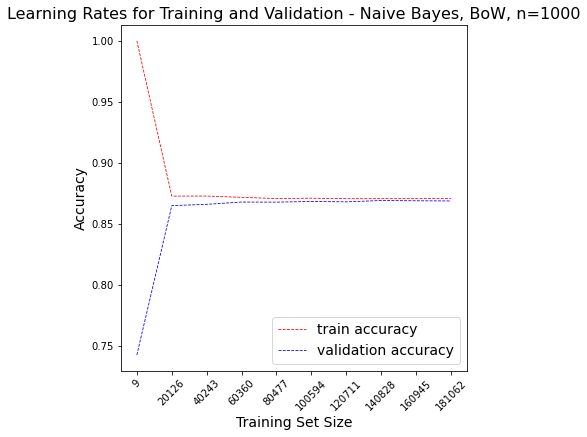

In [11]:
plot_learning_curves_feed_m(NB_clf, X_train_transformed, y_array, 
                           'Naive Bayes, BoW, n=1000')

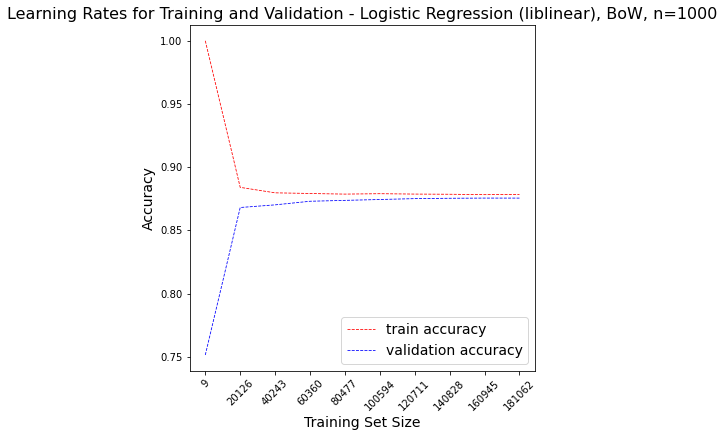

In [12]:
plot_learning_curves_feed_m(log_clf, X_train_transformed, y_array, 
                            'Logistic Regression (liblinear), BoW, n=1000')

As suspected, feeding rows to these simple models with a limited number of features does not improve accuracy.

### Fixed $m\approx250,000$; feed features $n$

To feed an increasing number of features, instead of recreating a learning curve that pre-processes an increasing number of features at every iteration, which would take a humongous amount of time, I pre-process this larger subset and feed increasing portions of it. 

### Pre-process subset with 50,000 features

In [13]:
try:
    # load X_train_transformed 
    X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_BoW_250k_50k.npz"))
    print('Loading X_train_transformed...')
except:
    print('Preprocessing X_array as BoW with m=250k, n=1k...')
    preprocess_pipeline = Pipeline([
        ("document_to_wordcount", Cmod.DocumentToWordCounterTransformer()),
        ("wordcount_to_vector", Cmod.WordCounterToVectorTransformer(vocabulary_size=50000)), # n=50k
    ])
    start_pipeline = time.time()
    X_train_transformed = preprocess_pipeline.fit_transform(X_array) # currently 250k
    # save preprocessed data
    sp.save_npz(os.path.join(proc_dir, 'X_train_transformed_BoW_250k_50k.npz'), X_train_transformed)
    # print processing time
    mins, secs = divmod(time.time() - start_pipeline, 60)
    print(f'Preprocessing time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')
    # Preprocessing time: 2 minute(s) and 41 second(s).

Loading X_train_transformed...


In [14]:
X_train_transformed

<251468x50001 sparse matrix of type '<class 'numpy.int32'>'
	with 2569112 stored elements in Compressed Sparse Row format>

In [15]:
def plot_learning_curves_feed_n(model, X, y, Xname):
    """Plot the learning curves for train and validation sets,
       by adding more features (n) and keeping the number of 
       rows (m) constant.
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
       Evaluates accuracy (TODO: implement other metrics)
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
    xs, train_acc, valid_acc = [], [], []

    # executive decision here, feeding 12 m data points
    for n in range(500, 50001, 4500):
        model.fit(X_train[:X.shape[0],:n], y_train)
        y_train_predict = model.predict(X_train[:X.shape[0],:n])
        y_valid_predict = model.predict(X_valid[:X.shape[0],:n])
        train_acc.append(accuracy_score(y_train, y_train_predict))
        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
        xs.append(str(n-1))

    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_axes([0.0, 
                       # dynamic x ticks would be len(range(x,y,z))
                       12, 
                       0.4, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, 
             label="train accuracy")
    plt.plot(xs, np.sqrt(valid_acc), 'b--', linewidth=.8, 
             label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", 
                       Xname]), 
              fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Numer of Features", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

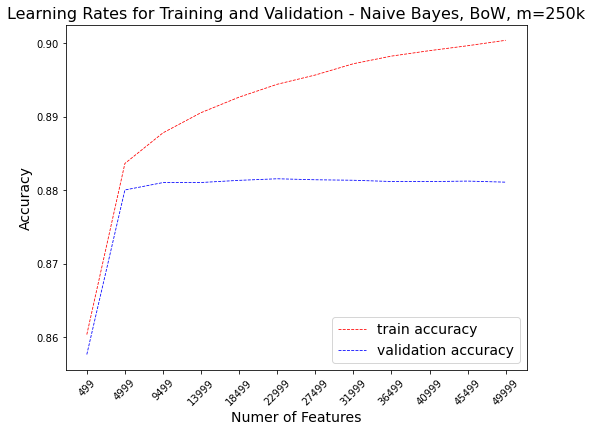

In [16]:
plot_learning_curves_feed_n(NB_clf, X_train_transformed, y_array, 
                            'Naive Bayes, BoW, m=250k')

Again, the Naive Bayes model is too simple to learn even with more features, it ends up just overfitting the training set. The validation accuracy is a bit higher than the model trained on 1,000 features, but I'll test the generalization with cross validation to gain a more realistic assessement.

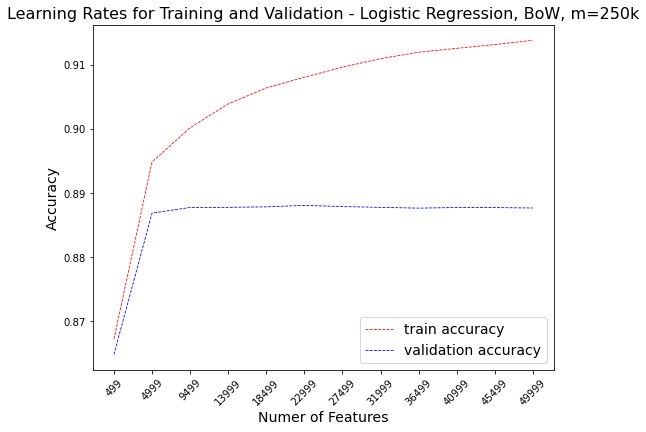

LR plot time: 1 minute(s) and 10 second(s).


In [17]:
start_plot = time.time()
plot_learning_curves_feed_n(log_clf, X_train_transformed, y_array, 
                            'Logistic Regression, BoW, m=250k')
mins, secs = divmod(time.time() - start_plot, 60)
print(f'LR plot time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')

The learning curve is similar, and we gain about half a percentage in accuracy.

Let's use cross validation to gain insight into the generalization of these models.

### Cross Validation 

In [18]:
score = cross_val_score(NB_clf, X_train_transformed, y_array, cv=5, verbose=3, scoring='accuracy')
print('Mean accuracy: ' + str(score.mean()))

[CV]  ................................................................
[CV] .................................... , score=0.776, total=   0.1s
[CV]  ................................................................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] .................................... , score=0.772, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.778, total=   0.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] .................................... , score=0.778, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.773, total=   0.1s
Mean accuracy: 0.7756414350309383


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [19]:
score = cross_val_score(log_clf, X_train_transformed, y_array, cv=5, verbose=3, scoring='accuracy')
print('Mean accuracy: ' + str(score.mean()))

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.789, total=  10.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s


[CV] .................................... , score=0.785, total=   7.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.0s remaining:    0.0s


[CV] .................................... , score=0.789, total=   6.4s
[CV]  ................................................................
[CV] .................................... , score=0.791, total=   8.7s
[CV]  ................................................................
[CV] .................................... , score=0.786, total=   7.1s
Mean accuracy: 0.7879849566093533


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.2s finished


Logistic Regression seems to be doing a little better than Naive Bayes at $78.8\%$ accuracy vs $77.6\%$ - but it takes 10x longer at $40s$ vs $0.4s$ for Naive Bayes.

### Peek at some predictions

In [20]:
NB_clf.fit(X_train_transformed, y_array)

MultinomialNB()

**Misclassified**

In [21]:
# print misclassifications in first 100 
# y_actual, y_pred, tweet
misclassified = []
for i,v in enumerate(NB_clf.predict(X_train_transformed[:100])):
    if v != y_array[:100][i]:
        print(y_array[:100][i], v, X_array[:100][i])
        misclassified.append(i)

0 1 jumping on to twitter in apparently the first time in 20 days 
1 0 Getting all organized before work starts again tomorrow. I think it's a good sign that I'm not dreading my alarm going off at 6am. 
0 1 @ShizukaWright i slept thru most of it.  how was yours?
1 0 @lotusheartbreak Yeah, I'll probably 'stop' when ALL of my stories are completely finished. That won't be for a while though. Wide awake. 
0 1 &quot;It's amazing what you can hide...Just by putting on a smile...&quot; 
0 1 @BigCinemaRon  EEEEP. fine darling. but now would be cool.....
1 0 @voipusers haha of course, didn't even really think of that 
0 1 The sun is teasing! It's popping up and then hiding!! 
1 0 LMAO!!! @damonDCclark eww! I hate Grits... I just eat lots of Frijoles @JessiDavis_ that works for me! 
0 1 attn dallas visitors: there are more things to do here than shop! jk I &lt;3 u seester. but not shopping marathons... 
0 1 The sun only always shines on TV, actually 
0 1 Happy birthday to me... Turned 23 yester

In [22]:
accuracy = 1 - len(misclassified)/100
print(f'Accuracy in first 100 rows = {accuracy}')

Accuracy in first 100 rows = 0.76


These do seem ambiguous at times, looking at some correctly classified examples.

**Correctly classified**

In [23]:
for i,v in enumerate(NB_clf.predict(X_train_transformed[:100])):
    if v == y_array[:100][i] and i < 20:
        print(y_array[:100][i], v, X_array[:100][i])

1 1 happy mothers day to all those special moms out there.... i luv u mommy!! 
1 1 Thank you to all our new followers.  If you haven't checked out the video for our upcoming single, please do: http://bit.ly/17OclK  
0 0 Ouch, arms are sunburned.  I didn't feel like I was spending too much time in the sun and silly me didn't put on sunscreen. 
1 1 &quot;You Really Got a Hold on Me&quot; by Zooey Deschanel @ZooeyDe &amp; M. Ward a.k.a. She &amp; Him. My new favorite song of all time. 
0 0 My stickers are fading... 
0 0 Hate it when you forget to lower your ISO after being inside and get grainy shots in perfect light outside...when in Paris 
1 1 @kathtrinder I had them for lunch  ooooh, green &amp; blacks  yay! lol. Friday and saturday are gonna be awesome!!
0 0 @ronilicious - SOUP is exactly what I'm in the mood for tonight. No Panera close to me though 
1 1 @MariahCarey So you don't know the song &quot;chihuaha&quot; from our SWISS singer DJ BOBO ? Haha !! It was a hit in 2003 here. But

And those do seem like more clearcut cases.

In [24]:
# time notebook
mins, secs = divmod(time.time() - start_notebook, 60)
print(f'Total running time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')

Total running time: 2 minute(s) and 16 second(s).


---